In [ ]:
#Automatic installation of libraries
!pip install pandas numpy matplotlib sklearn nltk seaborn pandas_profiling scikit-learn

In [2]:
import random
import re
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd
import string as st
from nltk import PorterStemmer, WordNetLemmatizer
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import nltk

nltk.download('all')

# Data Exploration

In [4]:
df = pd.read_csv('./datasets/profile_dataset.csv')

In [5]:
print(df.shape)

(2440, 2)


In [6]:
# Total type of unique categories
print("Unique categories:",df['type'].unique())

Unique categories: ['business' 'entertainment' 'politics' 'sport' 'tech']


In [7]:
df = df.drop_duplicates()

In [8]:
# Information about metadata
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2342 entries, 0 to 2439
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   news    2342 non-null   object
 1   type    2342 non-null   object
dtypes: object(2)
memory usage: 54.9+ KB


In [ ]:
report = ProfileReport(df)
report

C:\Users\erick\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


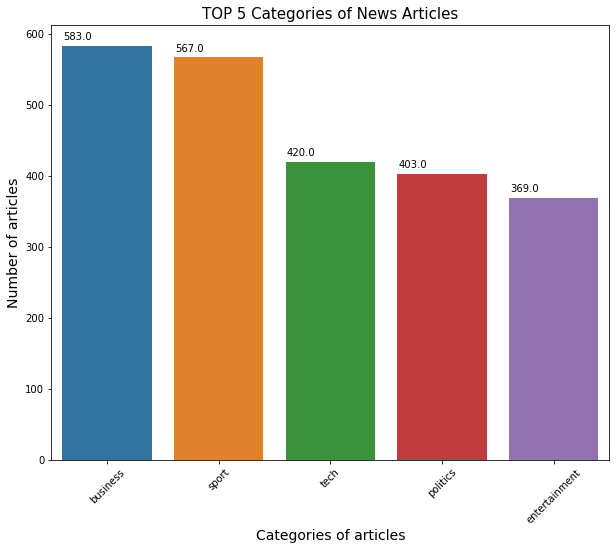

In [10]:
# Top categories by and number of articles per categories
cat_df = pd.DataFrame(df['type'].value_counts()).reset_index()
cat_df.rename(columns={'index':'news_classes','type':'numcat'}, inplace=True)

plt.figure(figsize=(10,8))
ax = sns.barplot(np.array(cat_df.news_classes)[:5], np.array(cat_df.numcat)[:5])
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.01, p.get_height() + 8))
plt.title("TOP 5 Categories of News Articles", size=15)
plt.xlabel("Categories of articles", size=14)
plt.xticks(rotation=45)
plt.ylabel("Number of articles", size=14)
plt.show()

# Text cleaning and dataset preparation

In [11]:
def remove_punct(text):
    return ("".join([ch for ch in text if ch not in st.punctuation]))

def clean_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove punctuation
    #text = text.translate(str.maketrans('', '', st.punctuation))
    text = remove_punct(text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Join the tokens back into a single string
    clean_text = ' '.join(tokens)

    return clean_text.strip()

In [12]:
def prepare_dataset(dataset):
    #Divide in features and labels. We're gonna do a tokenization and lemmatization process with the news features
    x = df['news'].tolist()
    y = df['type'].tolist()
    wordnet_lemmatizer = WordNetLemmatizer()
    print("Data preparation")
    print("Tokenization and Lemmatization process", end='', flush=True)
    for i, value in enumerate(x):
        x[i] = ' '.join([wordnet_lemmatizer.lemmatize(word) for word in clean_text(value).split()])
        
    
    #Train and test set split
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
    vect = TfidfVectorizer(min_df=2)

    #Training process
    X_train = vect.fit_transform(X_train)
    y_train = np.array(y_train)
    X_test = vect.transform(X_test)
    y_test = np.array(y_test)

    #Validation and test set split
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

    print("\n")
    print("Train set:" + str(X_train.shape))
    print("Validation set:" + str(X_val.shape))
    print("Test set:" + str(X_test.shape))

    return X_train, X_val, X_test, y_train, y_val, y_test, vect

# Models

In [13]:
def rf_train_model(X_train, y_train):
    model = RandomForestClassifier(n_estimators=200, max_depth=150, n_jobs=1)
    model.fit(X_train, y_train)
    return model

def svc_train_model(X_train, y_train):
    model = SVC(kernel='linear', gamma='auto', probability=True)
    model.fit(X_train, y_train)
    return model

def kn_train_model(X_train, y_train):
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_train, y_train)
    return model

def evaluation_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    result = classification_report(y_val, y_pred)
    acc = accuracy_score(y_val, y_pred)
    print(result)
    print("\nAccuracy: ", acc)

def evaluation_test_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    result = classification_report(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    print(result)
    print("\nAccuracy: ", acc)
    
def test_model_accuracy(model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return acc




# Set Users Preferences

In [14]:
topics = ["sport", "tech", "business", "politics", "entertainment"]

# Set preferences by users
def set_preferences(users):
    user_preferences = {}
    for user in users:
        preferences = []
        possibilities = list(topics)
        for pref in range(random.randint(1, 3)):
            category = random.choice(possibilities)
            preferences.append(category)
            possibilities.remove(category)
        user_preferences[user] = preferences
    return user_preferences

# Predict the document type
def predict_doc_type(doc, vect, model):
    document_cleaned = clean_text(doc)
    corpus = []
    corpus.append(document_cleaned)
    test_vect = vect.transform(corpus)
    return model.predict(test_vect)[0]


# Testing results
def run_test(vect, model):
    users = ["Gabriela", "Pablo", "Erick", "Marco", "Sam", "Luis"]
    users_preferences = set_preferences(users)
    print("\n")
    print("User preferences:")
    for user in users_preferences:
        print(user, "likes these topics:", users_preferences[user])
    print("\n")

    while True:
        try:
            test_corpus = input("Enter a text about a specific tpic. If you wanna reassign the preferences please type 'a' or if you wanna quit, please type 'e':\n")
        except ValueError:
            continue
        if test_corpus == "e":
            break
        if test_corpus == "a":
            users_preferences = set_preferences(users)
            print("\n")
            print("User preferences:")
            for user in users_preferences:
                print(user, "likes these topics:", users_preferences[user])
            print("\n")
            continue
            
        else:

            result = predict_doc_type(test_corpus, vect, model)
            if (result == "sport"):
                topic = result.upper()
            if (result == "tech"):
                topic = result.upper()
            if(result == "business"):
                topic = result.upper()
            if (result == "entertainment"):
                topic = result.upper()
            if (result == "politics"):
                topic = result.upper()
            print("\n")
            print("This article talks about "+ topic + " " + "and it's addressed to:")
            for user in users_preferences:
                if result in users_preferences[user]:
                    print(user)
            continue

# Rank Categories

In [15]:
def format_percentage(value):
    return f'{value:.2f}%'

In [16]:
def rank_top_categories(X_test, model, top_n=5):
    class_probabilities = model.predict_proba(X_test)
    summed_probabilities = np.mean(class_probabilities, axis=0)
    class_indices = np.argsort(summed_probabilities)[::-1][:top_n]
    ranked_classes = [(model.classes_[i], summed_probabilities[i]*100) for i in class_indices]
    rank_df = pd.DataFrame(ranked_classes, columns=['Category', 'Percentage'])
    rank_df['Percentage'] = rank_df['Percentage'].apply(format_percentage)
    for index, row in rank_df.iterrows():
        print(f"{row['Category']}: {row['Percentage']}")

# Test Project

In [17]:
def test_project():

    X_train, X_val, X_test, y_train, y_val, y_test, vect = prepare_dataset(df)
        
    #Models Calls
    svc_model = svc_train_model(X_train, y_train)
    rf_model = rf_train_model(X_train, y_train)
    kn_model = kn_train_model(X_train, y_train)
        
    # Models training
    print("\n")
    print("-----Models Training-----")
    
    # Suport Vector Machine
    print("\nSuport Vector Machine")
    evaluation_model(svc_model, X_val, y_val)
    # Random Forest
    print("\nRandom Forest")
    evaluation_model(rf_model, X_val, y_val)
    # K Neighbors
    print("\nK Neighbors")
    evaluation_model(kn_model, X_val, y_val)
    print("---------------------------------------")

    # Models testing
    print("\n")
    print("-----Models Testing-----\n")
    print("\nSuport Vector Machine")
    evaluation_test_model(svc_model, X_test, y_test)
    print("\nRandom Forest")
    evaluation_test_model(rf_model, X_test, y_test)
    print("\nK Neighbors")
    evaluation_test_model(kn_model, X_test, y_test)
    print("\n")
    print("\nModel Accuracies")
    print("Suport Vector Machine:", test_model_accuracy(svc_model, X_test, y_test))
    print("Random Forest:", test_model_accuracy(rf_model, X_test, y_test))
    #print("Neural Network:", test_model(nn_model, X_test, y_test))
    print("K Neighbors:", test_model_accuracy(kn_model, X_test, y_test))
    print("------------------------------")    
    
    print("\n-----Ranking of Categories for Support Vector Machine-----\n")
    rank_top_categories(X_test, svc_model)
    
    # Run test
    #We pass the vector and any model we have trained
    run_test(vect, svc_model)


In [ ]:
test_project()